In [1]:
PRE_TOKENIZER = ["ws", "gpt2", "llama3"]
VOCAB_SIZE = [500, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 128000, 256000, 512000]
FITTING_CORPORA = ["wikipedia", "mixed"]
OUT_PATH = "/shared/3/projects/hiatus/TOKENIZER_wegmann/tokenizer"
def get_name(corpus_name, pre_tokenizer, vocab_size):
    dir_name = f"{OUT_PATH}/{corpus_name}-{pre_tokenizer}-{vocab_size}/tokenizer.json"
    return dir_name

In [2]:
tokenizer_paths = [get_name("mixed", "ws", 32000), get_name("mixed", "gpt2", 32000), get_name("mixed", "llama3", 32000)]

In [4]:
from tokenizers import Tokenizer
import os

# Load tokenizers and extract vocabularies
vocabularies = {}
folder_names = []
for path in tokenizer_paths:
    # Extract the last folder name from the path
    folder_name = os.path.basename(os.path.dirname(path))
    folder_names.append(folder_name)
    tokenizer = Tokenizer.from_file(path)
    vocab = tokenizer.get_vocab()
    
    # Sort tokens based on their frequency (ID)
    sorted_tokens = sorted(vocab.items(), key=lambda item: item[1])
    
    # Store sorted tokens (by frequency) as a list of token strings
    vocabularies[folder_name] = [token for token, _ in sorted_tokens]

# Calculate truly unique tokens for each tokenizer
unique_tokens = {}
special_unique_tokens = {}

for name, vocab_list in vocabularies.items():
    # Union of vocabularies from the other tokenizers
    others = set.union(*(set(vocabularies[other_name]) for other_name in vocabularies if other_name != name))
    
    # Subtract the other vocabularies from the current one to get truly unique tokens
    unique_tokens[name] = [token for token in vocab_list if token not in others]
    
    # Special condition for tokenizers with "ws" in their name
    if "ws" in name:
        # Tokens not present in others, and not present when prefixed with "Ġ"
        special_unique_tokens[name] = [token for token in unique_tokens[name] if f"Ġ{token}" not in others]

# Function to get examples from sorted tokens (assuming order by frequency)
def get_ordered_examples(tokens):
    n = len(tokens)
    return {
        "most_common": tokens[:10],
        "middle": tokens[n // 2 - 5: n // 2 + 4],
        "least_common": tokens[-10:]
    }

# Prepare the results including token examples with frequency considerations
results_with_special_unique = {
    'vocab_sizes': {name: len(vocab_list) for name, vocab_list in vocabularies.items()},
    'common_token_count_all': len(set.intersection(*(set(vocabularies[name]) for name in vocabularies))),
    'unique_tokens_count': {name: len(tokens) for name, tokens in unique_tokens.items()},
    'unique_tokens_examples': {name: get_ordered_examples(tokens) for name, tokens in unique_tokens.items()},
    'special_unique_tokens_count': {name: len(tokens) for name, tokens in special_unique_tokens.items()},
    'special_unique_tokens_examples': {name: get_ordered_examples(tokens) for name, tokens in special_unique_tokens.items()},
    'pairwise_common_tokens': {f"{folder_names[i]} & {folder_names[j]}": len(set(vocabularies[folder_names[i]]).intersection(set(vocabularies[folder_names[j]]))) for i in range(len(folder_names)) for j in range(i + 1, len(folder_names))}
}

In [5]:
# Print the results
print("Vocabulary Sizes:")
for name, size in results_with_special_unique['vocab_sizes'].items():
    print(f"{name}: {size} tokens")

print(f"\nCommon Tokens Across All: {results_with_special_unique['common_token_count_all']}")

print("\nTruly Unique Tokens with Frequency Examples:")
for name, tokens in unique_tokens.items():
    print(f"{name}: {len(tokens)} unique tokens")
    examples = results_with_special_unique['unique_tokens_examples'][name]
    print(f"Most Common: {examples['most_common']}")
    print(f"Middle: {examples['middle']}")
    print(f"Least Common: {examples['least_common']}")

print("\nSpecial Unique Tokens for 'ws' Tokenizers with Frequency Examples:")
for name, tokens in special_unique_tokens.items():
    print(f"{name}: {len(tokens)} special unique tokens")
    examples = results_with_special_unique['special_unique_tokens_examples'][name]
    print(f"Most Common: {examples['most_common']}")
    print(f"Middle: {examples['middle']}")
    print(f"Least Common: {examples['least_common']}")

print("\nPairwise Common Tokens:")
for pair, count in results_with_special_unique['pairwise_common_tokens'].items():
    print(f"{pair}: {count} common tokens")

Vocabulary Sizes:
mixed-ws-32000: 0 tokens
mixed-gpt2-32000: 32000 tokens
mixed-llama3-32000: 32000 tokens

Common Tokens Across All: 0

Truly Unique Tokens with Frequency Examples:
mixed-ws-32000: 0 unique tokens
Most Common: []
Middle: []
Least Common: []
mixed-gpt2-32000: 3490 unique tokens
Most Common: ['Ġ1', 'Ġ2', 'ĊĠĠĠ', 'ĊĠĠĠĠĠĠĠĠ', 'ĊĠĠĠĠĠĠĠ', 'Ġ0', 'Ġ3', 'ĊĠ', 'Ġ4', 'Ġ5']
Middle: ['carbon', 'wg', 'orange', 'intellig', 'vim', 'Ġ176', 'goes', 'outside', 'Ġ650']
Least Common: ['DEP', 'Ġadminister', 'RewriteRule', 'mnt', 'Ġuno', 'Ġslender', 'Ġomit', 'Ġchords', 'Ġamet', 'Ġurgency']
mixed-llama3-32000: 3490 unique tokens
Most Common: ['.Ċ', '.ĊĊ', ';Ċ', ',Ċ', ')Ċ', '>Ċ', ');Ċ', 'âĢĻs', ':ĊĊ', 'Ġ{Ċ']
Middle: ['.location', '-nav', 'empor', 'âĢľBut', '-sl', 'Ġub', '.equals', '=False', 'ĠImper']
Least Common: ['âĢľWhen', '.Event', ':Name', '.im', '916', 'lyph', '878', '965', '795', '698']

Special Unique Tokens for 'ws' Tokenizers with Frequency Examples:
mixed-ws-32000: 0 special uniqu

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

common_all = results_with_special_unique['common_token_count_all']

ws_only = 

# Corrected intersections
ws_gpt2_exclusive = 11314 - common_all
ws_llama3_exclusive = 10112 - common_all
gpt2_llama3_exclusive = 28510 - common_all

# Create the Venn diagram with corrected values
venn3(subsets=(ws_only, gpt2_only, ws_gpt2_exclusive, llama3_only, ws_llama3_exclusive, gpt2_llama3_exclusive, common_all),
      set_labels=('ws', 'gpt2', 'llama3'))

plt.title("Corrected Venn Diagram of Vocabulary Sizes")
plt.show()

In [9]:
VOCAB_SIZE = [500, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 128000, 256000, 512000]
tokenizer_paths = [get_name("mixed", "gpt2", v_size) for v_size in VOCAB_SIZE]

In [7]:
# Load tokenizers and extract vocabularies
vocabularies = {}
for path in tokenizer_paths:
    # Extract the last folder name from the path
    folder_name = os.path.basename(os.path.dirname(path))
    tokenizer = Tokenizer.from_file(path)
    vocab = tokenizer.get_vocab()
    
    # Sort tokens based on their frequency (ID) and store them
    sorted_tokens = sorted(vocab.items(), key=lambda item: item[1])
    vocabularies[folder_name] = [token for token, _ in sorted_tokens]

# Calculate the overlap for consecutive tokenizers and find newly added tokens
overlap_ratios = {}
added_tokens_examples = {}
folder_names = list(vocabularies.keys())

for i in range(len(folder_names) - 1):
    name_1 = folder_names[i]
    name_2 = folder_names[i + 1]
    print(f"At pair {(name_1, name_2)}")
    
    # Get vocabularies as ordered lists
    vocab_1 = vocabularies[name_1]
    vocab_2 = vocabularies[name_2]
    
    # Calculate the overlap
    overlap = len(set(vocab_1).intersection(set(vocab_2)))
    added = set(vocab_2) - set(vocab_1)
    smaller_vocab_size = min(len(vocab_1), len(vocab_2))
    
    # Calculate the overlap ratio
    overlap_ratio = overlap / smaller_vocab_size
    overlap_ratios[f"{name_1} & {name_2}"] = overlap_ratio
    
    print("Getting examples of newly added tokens.")
    # sort new tokens by frequency
    added_tokens = [token for token in vocab_2 if token in added]
    n = len(added_tokens)
    print(added_tokens[:100])
    
    # Get examples of the most frequent, middle, and least frequent added tokens
    examples = {
        "most_frequent": added_tokens[:10],
        "middle": added_tokens[max(0, n//2 - 5):max(0, n//2 + 5)],
        "least_frequent": added_tokens[-10:]
    }
    added_tokens_examples[f"{name_1} -> {name_2}"] = examples

# Print the results
print("Overlap Ratios between Consecutive Tokenizers:")
for pair, ratio in overlap_ratios.items():
    print(f"{pair}: {ratio:.2f}")

print("\nExamples of Added Tokens:")
for transition, examples in added_tokens_examples.items():
    print(f"\nTransition: {transition}")
    print("Most Frequent Added Tokens:", examples['most_frequent'])
    print("Middle Added Tokens:", examples['middle'])
    print("Least Frequent Added Tokens:", examples['least_frequent'])

At pair ('mixed-gpt2-500', 'mixed-gpt2-1000')
Getting examples of newly added tokens.
['Ġget', 'ge', 'ide', 'age', 'ies', 'Ġgo', 'Ġcl', 'very', 'ound', 'Ġkn', ');', 'ass', 'Ġone', 'ast', 'Ġjust', 'Ġwould', 'Ġwill', 'ime', '**', 'Ġsome', 'ĊĊ', 'ĠO', 'Ġthere', 'au', 'ich', 'Ġany', 'able', 'ure', 'ake', 'ile', 'Ġabout', 'ther', 'Ġwhat', 'ong', 'ink', 'ud', 'ff', 'to', 'ction', 'iz', 'Ġher', 'ice', 'are', 'per', '//', 'Ġar', 'Ġhas', 'Ġknow', 'Ġad', 'ple', 'ough', 'og', 'ĠJ', 'ase', 'Ġ{', 'Ġhad', 'Ġi', 'The', 'ĊĠĠĠĠĠĠĠ', 'ear', 'Ġqu', 'Ġmore', 'Ġwhen', 'av', 'ood', ').', 'Ġ0', 'ble', 'ks', 'Ġim', 'ult', 'ated', 'Ġ3', 'ous', 'ite', 'Ġen', 'int', 'Ġfe', 'ub', 'ace', 'Ġte', 'Ġno', 'Ġwho', 'ial', 'so', 'Ġthem', 'ans', 'Ġwhich', 'xt', 'cl', "'m", 'con', 'hat', 'orm', 'hing', 'ions', 'âĢľ', 'Ġ+', '="', 'ry']
At pair ('mixed-gpt2-1000', 'mixed-gpt2-2000')
Getting examples of newly added tokens.
['ues', 'Ġpers', '11', 'Ġnum', 'ever', 'Ġused', 'Ġown', 'Ġlittle', 'ven', 'oad', 'Ġcur', 'Ġ7', 'ĊĠĠĠĠĠ',

Getting examples of newly added tokens.
['5413', 'ĠNetOffice', 'Ġsweetbreads', 'ĠBarren', 'ĠBarChart', 'Ġeightfold', 'serverless', 'styleSheet', 'ĠMonoclonal', 'ĠMonotone', 'ĠPoliti', 'Ġdimorphic', 'Sims', 'althed', 'Ġletterpress', 'Ġlegalising', 'SubFolder', 'Ġedgewise', 'SQLState', 'ĠCrue', 'ĠCrumble', 'rdl', 'DBB', 'Attaboy', 'NUMA', 'Ġrubrum', 'Ð¼ÑĸÐ½', 'showers', 'dsb', 'ĠRemovals', 'Ġjego', 'ĠLogEntry', 'intell', 'ominaga', 'ĠSamy', 'ĠITIL', 'Ġimplodes', 'ĠUKM', 'Ġporcini', 'Ġbowmen', 'GroupList', 'GroupInfo', 'ĠYOUTH', 'Ġfreep', 'Ġbriefcases', 'Ġconsequatur', 'ĠMattson', 'roading', 'Ã¼cker', 'repetitions', 'GLOW', 'Ġmiata', 'ĠÐºÐ¾Ð¶', 'Ġjournaled', 'Ġjoan', 'aksud', 'ĠInterl', 'ĠManyToOne', 'ĠDOCTEST', 'ĠEnglanders', 'PageID', 'ThreadContext', 'HAWK', 'ĠUszk', 'CMU', 'ĠMaglor', 'Detalle', 'igenes', 'Ġflashier', 'Ġhungary', 'InstanceCount', 'ĠDela', 'uhc', 'controlgroup', 'NETs', 'GETD', 'Postion', 'PostBuildEvent', 'PMO', 'Ġtipica', 'Offense', 'ĠBetrayed', 'ĠÐ´ÑĥÐ±Ð»Ð¸', 'ĠâĢ²('

At pair ('mixed-gpt2-500', 'mixed-gpt2-1000')
Getting examples of newly added tokens.
At pair ('mixed-gpt2-1000', 'mixed-gpt2-2000')
Getting examples of newly added tokens.
At pair ('mixed-gpt2-2000', 'mixed-gpt2-4000')
Getting examples of newly added tokens.
At pair ('mixed-gpt2-4000', 'mixed-gpt2-8000')
Getting examples of newly added tokens.
At pair ('mixed-gpt2-8000', 'mixed-gpt2-16000')
Getting examples of newly added tokens.
At pair ('mixed-gpt2-16000', 'mixed-gpt2-32000')
Getting examples of newly added tokens.
At pair ('mixed-gpt2-32000', 'mixed-gpt2-64000')
Getting examples of newly added tokens.
At pair ('mixed-gpt2-64000', 'mixed-gpt2-128000')
Getting examples of newly added tokens.
At pair ('mixed-gpt2-128000', 'mixed-gpt2-256000')
Getting examples of newly added tokens.
At pair ('mixed-gpt2-256000', 'mixed-gpt2-512000')
Getting examples of newly added tokens.


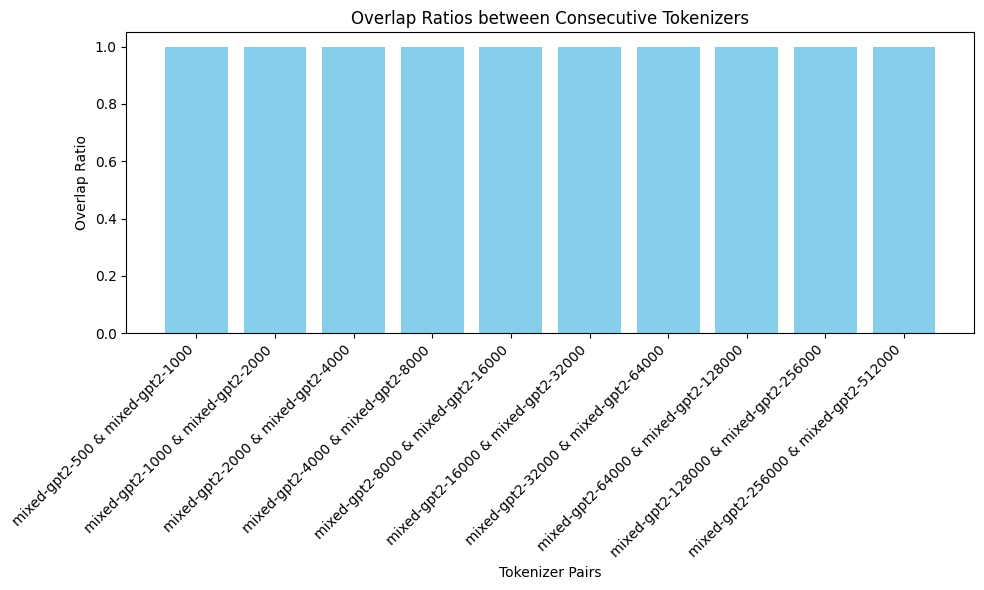

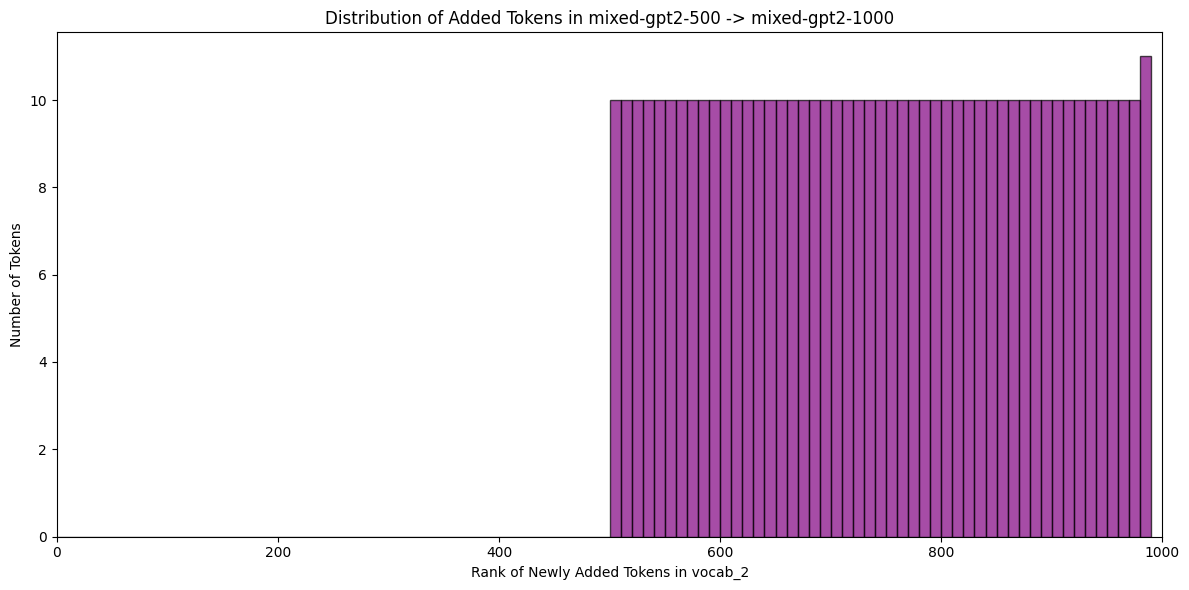

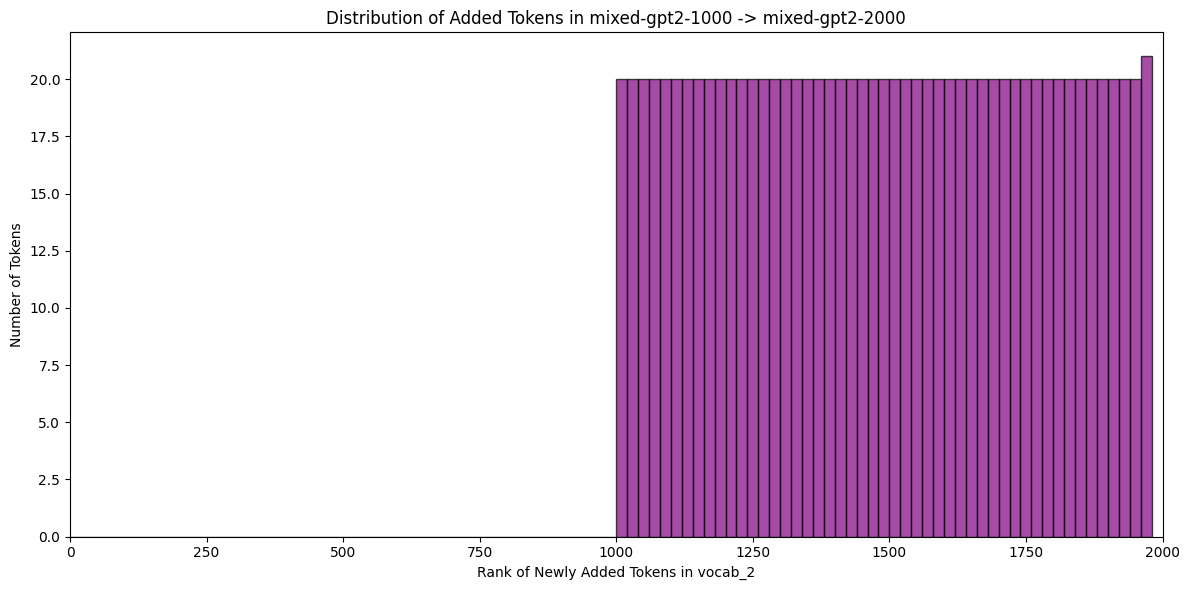

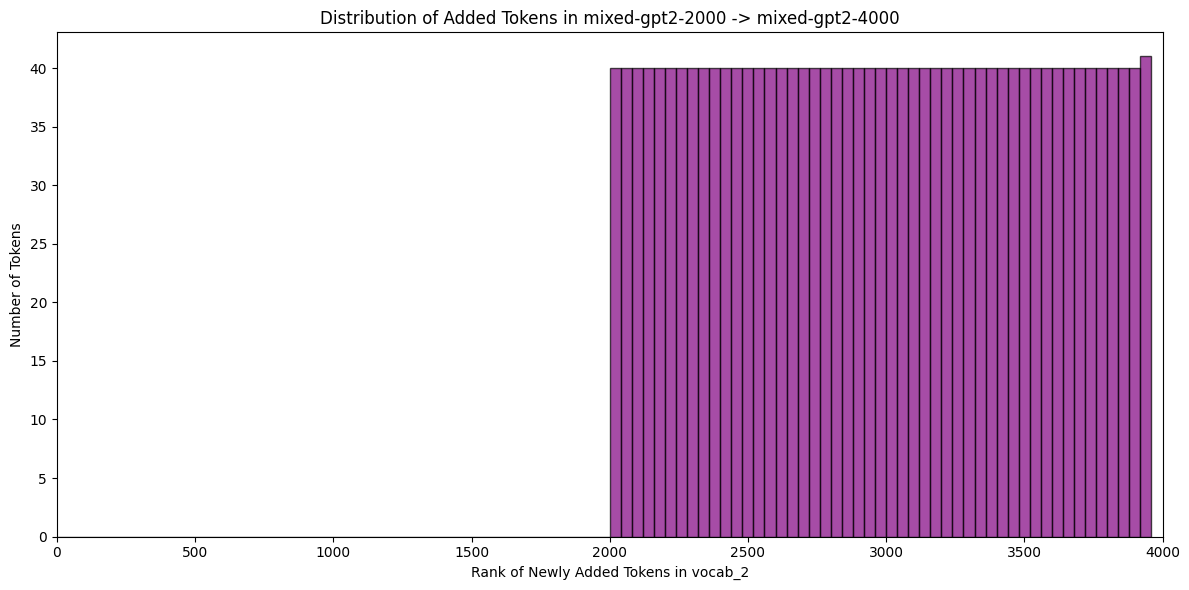

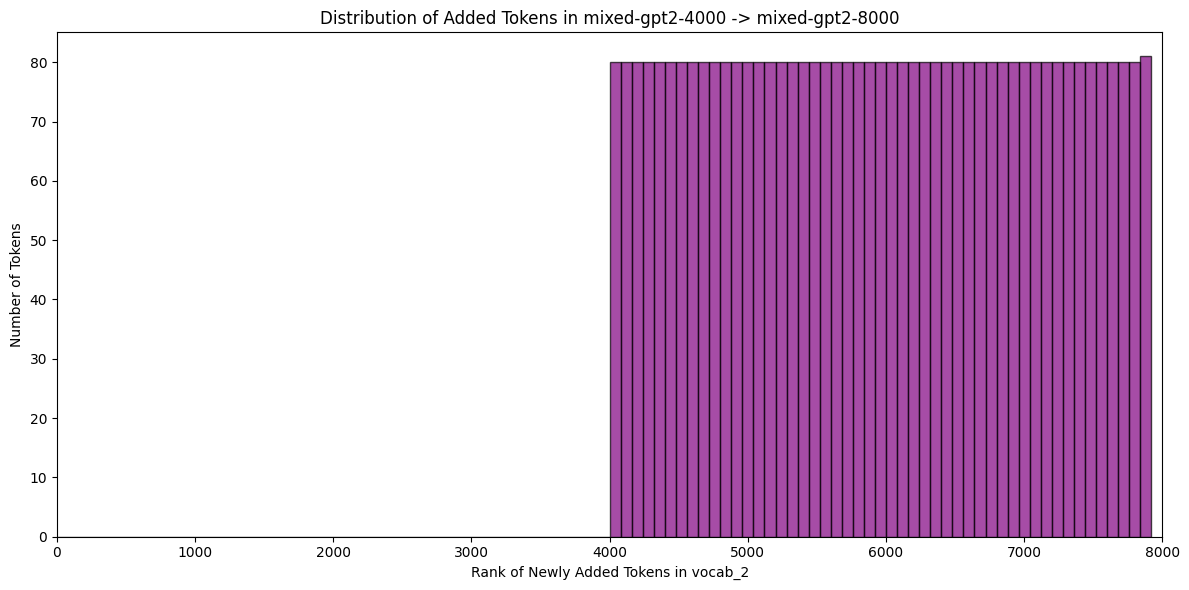

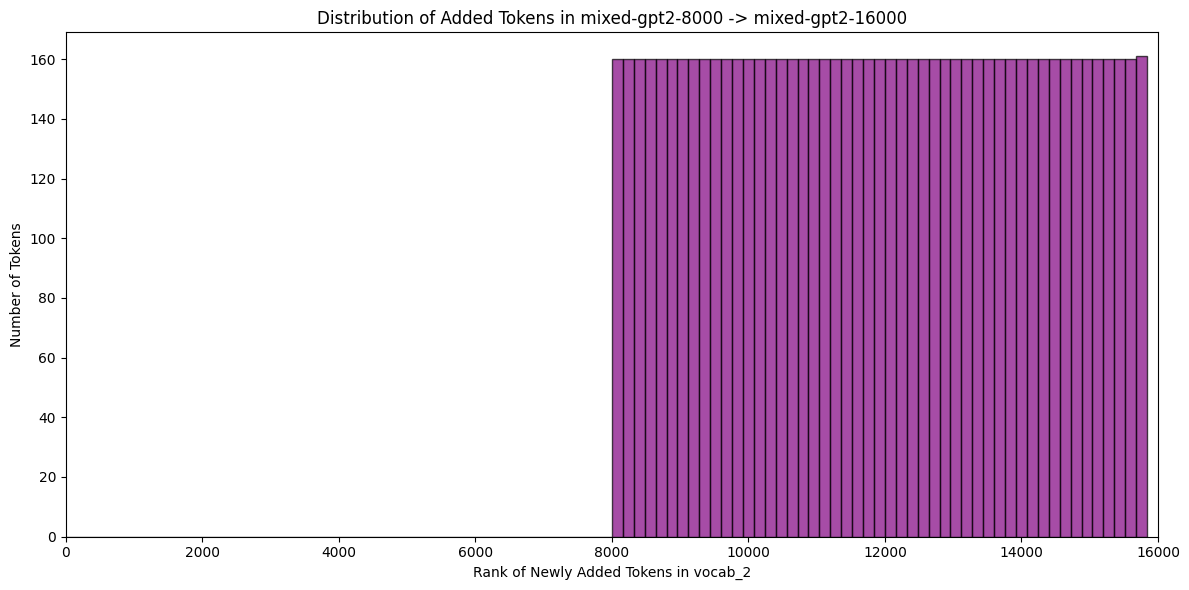

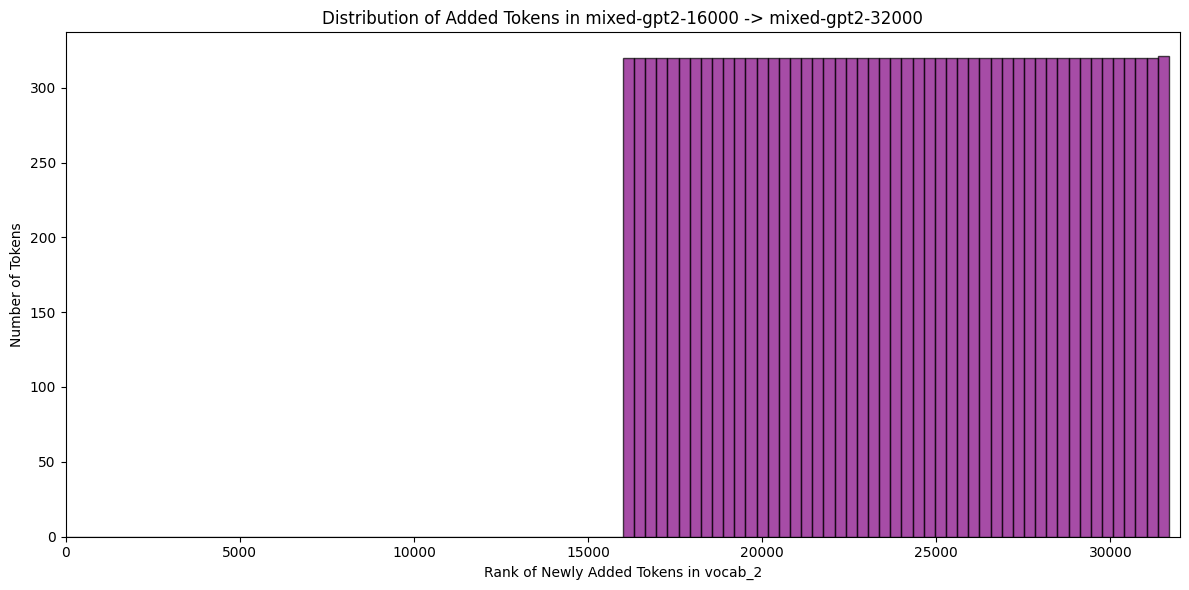

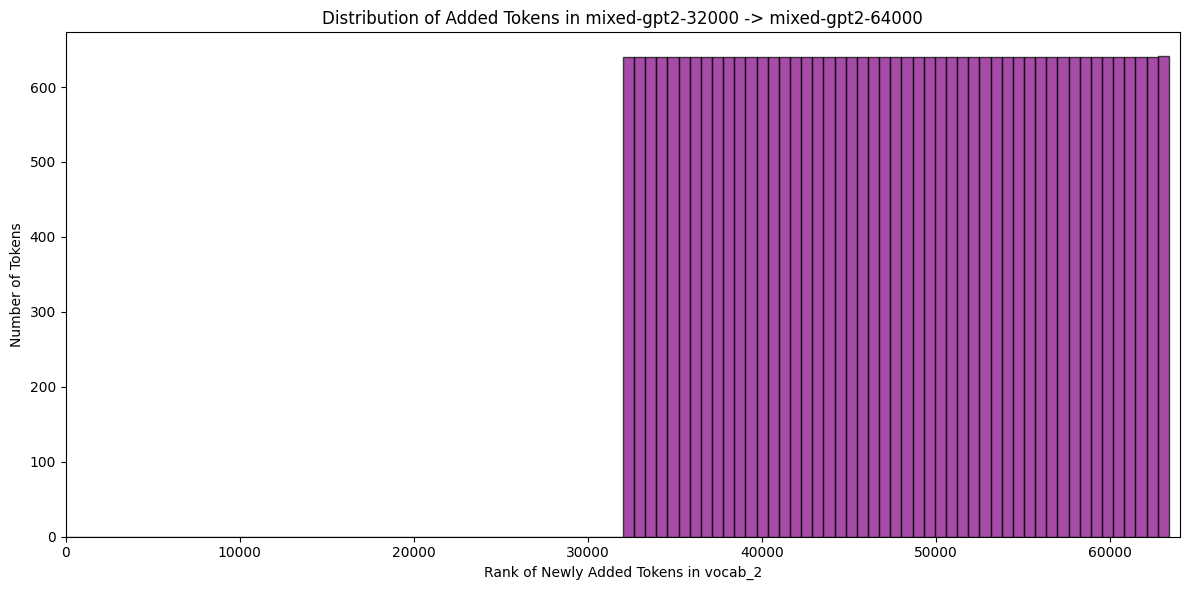

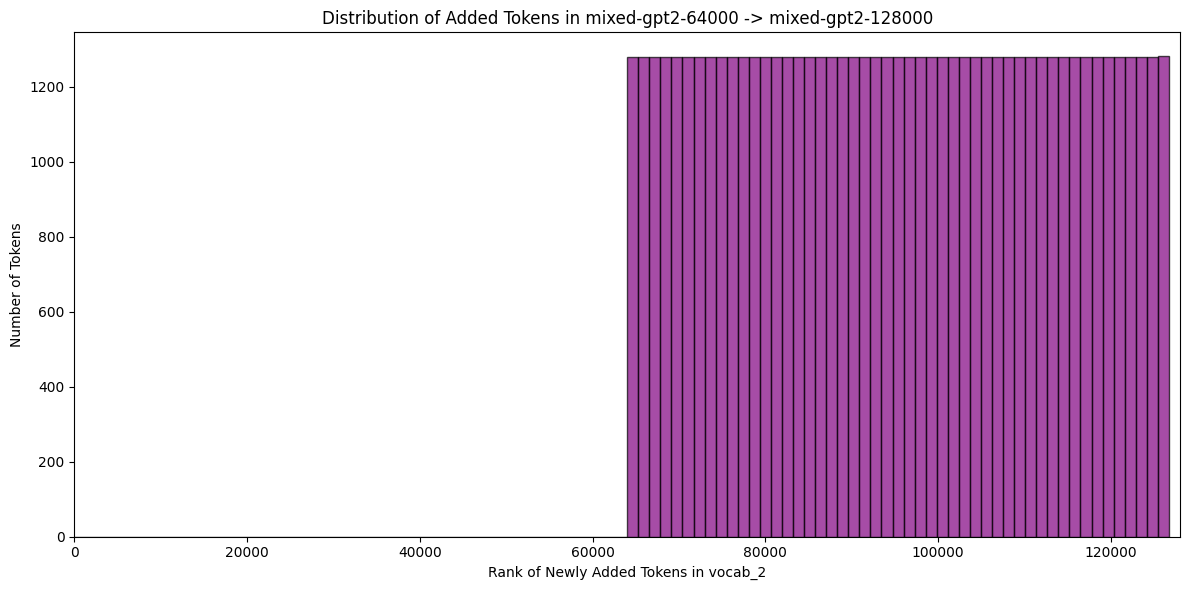

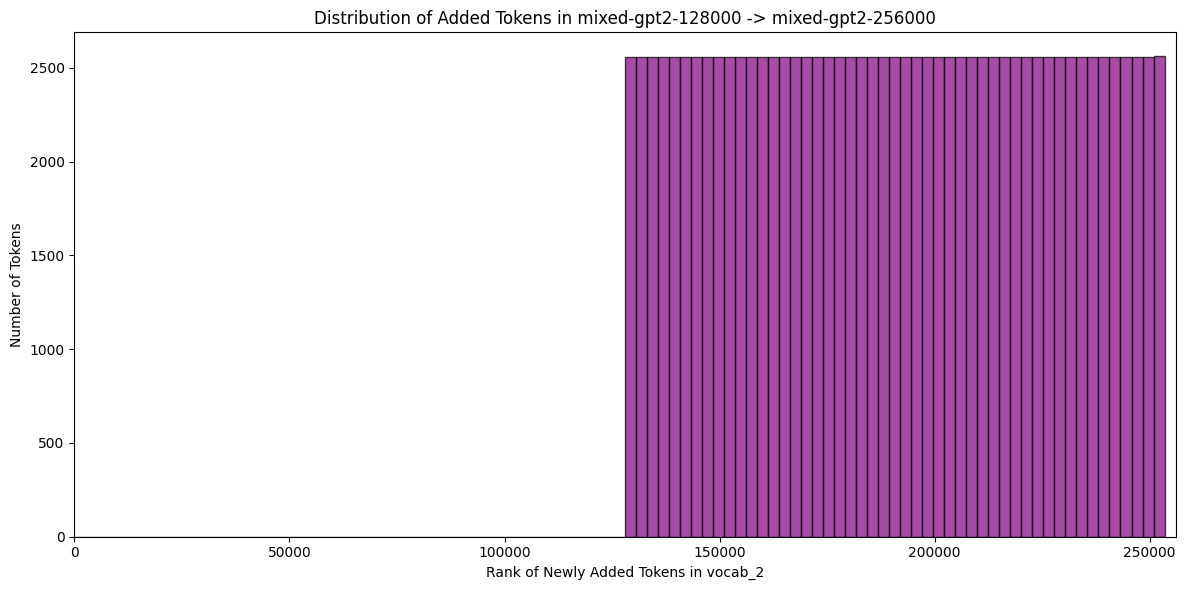

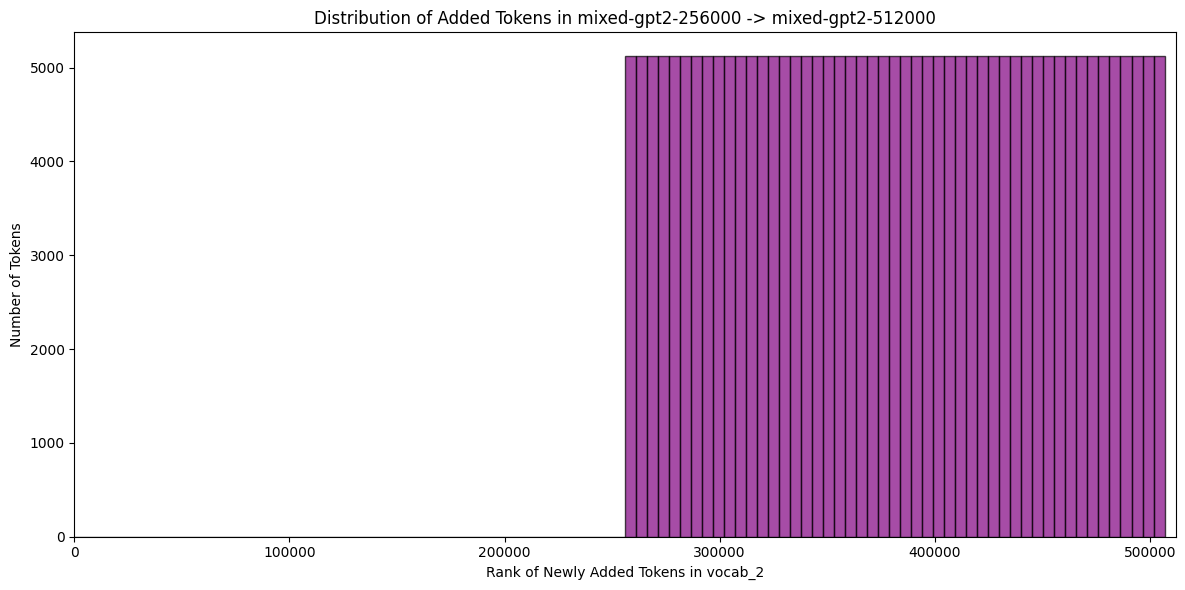

In [14]:
vocabularies = {}
vocab_dicts = {}
for path in tokenizer_paths:
    # Extract the last folder name from the path
    folder_name = os.path.basename(os.path.dirname(path))
    tokenizer = Tokenizer.from_file(path)
    vocab = tokenizer.get_vocab()
    vocab_dicts[folder_name] = vocab
    
    # Sort tokens based on their frequency (ID) and store them
    sorted_tokens = sorted(vocab.items(), key=lambda item: item[1])
    vocabularies[folder_name] = [token for token, _ in sorted_tokens]

# Calculate the overlap for consecutive tokenizers and find newly added tokens
overlap_ratios = {}
added_tokens_positions = {}
folder_names = list(vocabularies.keys())

for i in range(len(folder_names) - 1):
    name_1 = folder_names[i]
    name_2 = folder_names[i + 1]
    print(f"At pair {(name_1, name_2)}")
    
    # Get vocabularies as ordered lists
    vocab_1 = vocabularies[name_1]
    vocab_2 = vocabularies[name_2]
    
    # Calculate the overlap
    overlap = len(set(vocab_1).intersection(set(vocab_2)))
    added = set(vocab_2) - set(vocab_1)
    smaller_vocab_size = min(len(vocab_1), len(vocab_2))
    
    # Calculate the overlap ratio
    overlap_ratio = overlap / smaller_vocab_size
    overlap_ratios[f"{name_1} & {name_2}"] = overlap_ratio
    
    print("Getting examples of newly added tokens.")
    # Determine the rank of each newly added token in vocab_2
    added_tokens_positions[name_1 + " -> " + name_2] = [rank for rank, token in enumerate(vocab_2) if token in added]

# Visualization

# Plot overlap ratios
plt.figure(figsize=(10, 6))
pairs = list(overlap_ratios.keys())
ratios = list(overlap_ratios.values())
plt.bar(pairs, ratios, color='skyblue')
plt.xlabel('Tokenizer Pairs')
plt.ylabel('Overlap Ratio')
plt.title('Overlap Ratios between Consecutive Tokenizers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot distribution of added tokens in vocab_2
for transition, positions in added_tokens_positions.items():
    vocab_size = len(vocabularies[transition.split(" -> ")[1]])
    bin_size = max(1, vocab_size // 100)  # Ensure at least one token per bin

    plt.figure(figsize=(12, 6))
    plt.hist(positions, bins=range(0, vocab_size, bin_size), color='purple', alpha=0.7, edgecolor='black')
    plt.xlim(0, vocab_size)  # Consistent x-axis range
    plt.xlabel('Rank of Newly Added Tokens in vocab_2')
    plt.ylabel('Number of Tokens')
    plt.title(f'Distribution of Added Tokens in {transition}')
    plt.tight_layout()
    plt.show()